## _Reference taken from Youtube, Google and Packages offical site_ 
## _Standard part of code taken directly from web_.

---------------------------

---------------------------

## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [45]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [46]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [47]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [48]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [49]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [50]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [51]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [52]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [53]:
target = 'survived'

In [54]:
# Select numeric variables (excluding the target variable)
vars_num = data.select_dtypes(include=[np.number]).columns.tolist()
vars_num.remove(target)

# Select categorical variables
vars_cat = data.select_dtypes(include=[object]).columns.tolist()

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 5
Number of categorical variables: 4


### Find missing values in variables

In [55]:
# first in numerical variables

# Calculate the proportion of missing values in each numeric variable
missing_prop = data[vars_num].isnull().mean()

# Print the output
print(missing_prop)

pclass    0.000000
age       0.200917
sibsp     0.000000
parch     0.000000
fare      0.000764
dtype: float64


In [56]:
# now in categorical variables
# Calculate the proportion of missing values in each categorical variable
missing_prop = data[vars_cat].isnull().mean()

# Print the output
print(missing_prop)


sex         0.000000
cabin       0.774637
embarked    0.001528
title       0.000000
dtype: float64


### Determine cardinality of categorical variables

In [57]:
# Count the number of unique values in each categorical variable
unique_counts = data[vars_cat].nunique()

# Print the output
print(unique_counts)

sex           2
cabin       181
embarked      3
title         5
dtype: int64


### Determine the distribution of numerical variables

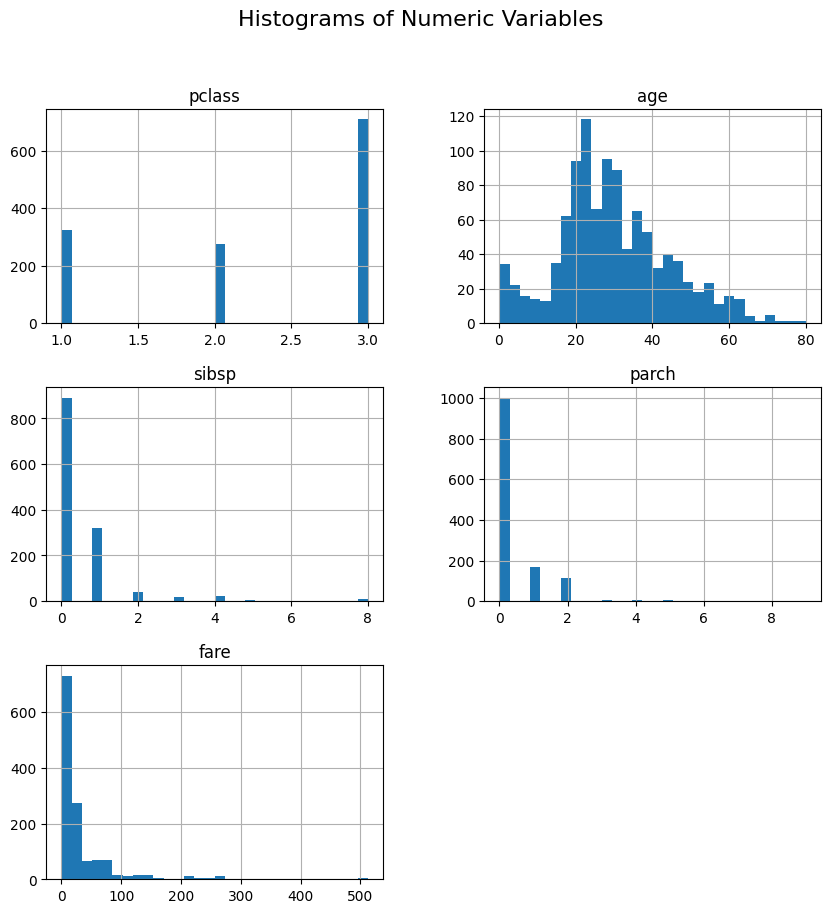

In [58]:
# Create histograms for each numeric variable
data[vars_num].hist(bins=30, figsize=(10,10))

# Add a title to the figure
plt.suptitle('Histograms of Numeric Variables', fontsize=16)

# Display the figure
plt.show()

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [59]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [60]:
# Extract the first letter of the 'cabin' variable in the training set
X_train['cabin'] = X_train['cabin'].str[0]

# Print the unique values of the 'cabin' variable in the training set
print(X_train['cabin'].unique())

[nan 'E' 'F' 'A' 'C' 'D' 'B' 'T' 'G']


In [61]:
# Extract the first letter of the 'cabin' variable in the training set
X_test['cabin'] = X_test['cabin'].str[0]

# Print the unique values of the 'cabin' variable in the training set
print(X_test['cabin'].unique())

[nan 'G' 'E' 'C' 'B' 'A' 'F' 'D']


### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [62]:
for var in ['age','fare']:
    
    # create binary variable indicating missing values
    X_train[var+'_NA'] = np.where(X_train[var].isnull(), 1, 0)
    X_test[var+'_NA'] = np.where(X_test[var].isnull(), 1, 0)
    
    # replace missing values with median
    median_val = X_train[var].median()
    X_train[var].fillna(median_val, inplace=True)
    X_test[var].fillna(median_val, inplace=True)
    
# check for missing values
print(X_train[['age', 'fare']].isnull().sum())

age     0
fare    0
dtype: int64


### Replace Missing data in categorical variables with the string **Missing**

In [63]:
X_train[vars_cat] = X_train[vars_cat].fillna('Missing')
X_test[vars_cat] = X_test[vars_cat].fillna('Missing')

In [64]:
X_train.isnull().sum()

pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
cabin       0
embarked    0
title       0
age_NA      0
fare_NA     0
dtype: int64

In [65]:
X_test.isnull().sum()

pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
cabin       0
embarked    0
title       0
age_NA      0
fare_NA     0
dtype: int64

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [66]:
def find_frequent_labels(df, var, rare_perc):
 
    df = df.copy()
    
    tmp = df.groupby(var)[var].count() / len(df)
    
    return tmp[tmp > rare_perc].index
    



In [67]:

for var in vars_cat:
    
    # find the frequent categories
    frequent_ls = find_frequent_labels(X_train, var, 0.05)
    
    # replace rare categories by the string "Rare"
    X_train[var] = np.where(X_train[var].isin(
        frequent_ls), X_train[var], 'Rare')
    
    X_test[var] = np.where(X_test[var].isin(
        frequent_ls), X_test[var], 'Rare')

In [68]:
X_train[vars_cat].nunique()

sex         2
cabin       3
embarked    4
title       4
dtype: int64

In [69]:
X_test[vars_cat].nunique()

sex         2
cabin       3
embarked    3
title       4
dtype: int64

### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [70]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

ct = ColumnTransformer(transformers=[('OHEncode',OneHotEncoder(drop='first'),vars_cat)],remainder='passthrough')
X_train = np.array(ct.fit_transform(X_train))
X_test = np.array(ct.transform(X_test))

In [71]:
X_train 

array([[  1.    ,   1.    ,   0.    , ...,   7.925 ,   0.    ,   0.    ],
       [  0.    ,   0.    ,   1.    , ..., 134.5   ,   0.    ,   0.    ],
       [  1.    ,   1.    ,   0.    , ...,   7.7333,   1.    ,   0.    ],
       ...,
       [  0.    ,   1.    ,   0.    , ...,   7.7333,   1.    ,   0.    ],
       [  0.    ,   1.    ,   0.    , ...,  36.75  ,   0.    ,   0.    ],
       [  0.    ,   1.    ,   0.    , ...,  15.5   ,   0.    ,   0.    ]])

In [72]:
X_test 

array([[ 1.    ,  1.    ,  0.    , ...,  7.8958,  0.    ,  0.    ],
       [ 0.    ,  1.    ,  0.    , ..., 21.    ,  0.    ,  0.    ],
       [ 1.    ,  1.    ,  0.    , ..., 27.    ,  0.    ,  0.    ],
       ...,
       [ 1.    ,  1.    ,  0.    , ..., 13.    ,  0.    ,  0.    ],
       [ 1.    ,  1.    ,  0.    , ..., 13.    ,  0.    ,  0.    ],
       [ 1.    ,  1.    ,  0.    , ...,  8.05  ,  1.    ,  0.    ]])

### Scale the variables

- Use the standard scaler from Scikit-learn

In [73]:
scaler = StandardScaler()
#  fit  the scaler to the train set
scaler.fit(X_train)

# transform the train and test set
X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

In [74]:
X_train

array([[ 0.76104239,  0.55123545, -0.43407632, ..., -0.50478215,
        -0.49492069, -0.03091962],
       [-1.31398725, -1.81410683,  2.30374237, ...,  1.97155505,
        -0.49492069, -0.03091962],
       [ 0.76104239,  0.55123545, -0.43407632, ..., -0.5085326 ,
         2.02052574, -0.03091962],
       ...,
       [-1.31398725,  0.55123545, -0.43407632, ..., -0.5085326 ,
         2.02052574, -0.03091962],
       [-1.31398725,  0.55123545, -0.43407632, ...,  0.05915559,
        -0.49492069, -0.03091962],
       [-1.31398725,  0.55123545, -0.43407632, ..., -0.35658342,
        -0.49492069, -0.03091962]])

In [75]:
X_test

array([[ 0.76104239,  0.55123545, -0.43407632, ..., -0.50535342,
        -0.49492069, -0.03091962],
       [-1.31398725,  0.55123545, -0.43407632, ..., -0.24898038,
        -0.49492069, -0.03091962],
       [ 0.76104239,  0.55123545, -0.43407632, ..., -0.13159525,
        -0.49492069, -0.03091962],
       ...,
       [ 0.76104239,  0.55123545, -0.43407632, ..., -0.40549389,
        -0.49492069, -0.03091962],
       [ 0.76104239,  0.55123545, -0.43407632, ..., -0.40549389,
        -0.49492069, -0.03091962],
       [ 0.76104239,  0.55123545, -0.43407632, ..., -0.50233662,
         2.02052574, -0.03091962]])

## Logistic Regression model check - hyperparameter tunning 

In [76]:
log_reg =LogisticRegression(C=0.0005, random_state=0 )
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

print('Accuracy: %.3f' % accuracy_score(y_test.values, y_pred))
print('ROC-AUC : %.3f' % roc_auc_score(y_test.values, y_pred))

Accuracy: 0.702
ROC-AUC : 0.610


In [77]:
log_reg =LogisticRegression(C=0.0005, random_state=0,solver='liblinear',penalty='l1')
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

print('Accuracy: %.3f' % accuracy_score(y_test.values, y_pred))
print('ROC-AUC : %.3f' % roc_auc_score(y_test.values, y_pred))

Accuracy: 0.618
ROC-AUC : 0.500


In [78]:
log_reg =LogisticRegression(C=0.0005, random_state=0,solver='liblinear',penalty='l2')
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

print('Accuracy: %.3f' % accuracy_score(y_test.values, y_pred))
print('ROC-AUC : %.3f' % roc_auc_score(y_test.values, y_pred))

Accuracy: 0.771
ROC-AUC : 0.759


## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [79]:
log_reg =LogisticRegression(C=0.0005, random_state=0,solver='liblinear',penalty='l2')
log_reg.fit(X_train, y_train)

LogisticRegression(C=0.0005, random_state=0, solver='liblinear')

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [80]:
y_pred = log_reg.predict(X_test)

print('Accuracy: %.3f' % accuracy_score(y_test.values, y_pred))
print('ROC-AUC : %.3f' % roc_auc_score(y_test.values, y_pred))

Accuracy: 0.771
ROC-AUC : 0.759


That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**